## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Undestort Image
---

/calibration13.jpg


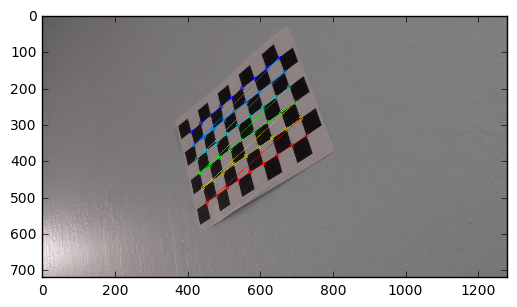

/calibration19.jpg


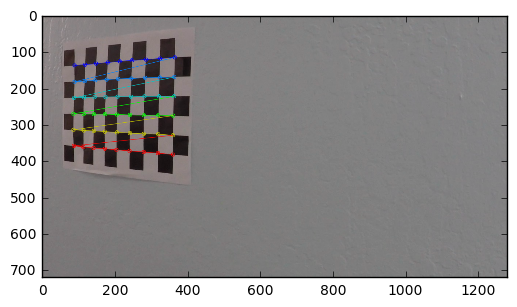

/calibration11.jpg


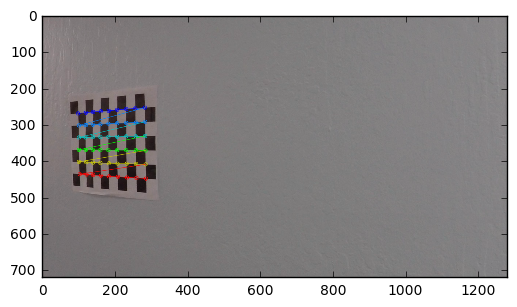

/calibration20.jpg


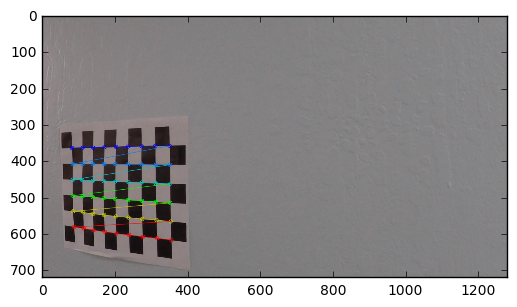

/calibration17.jpg


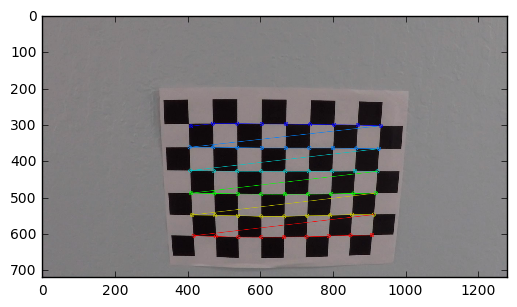

/calibration15.jpg


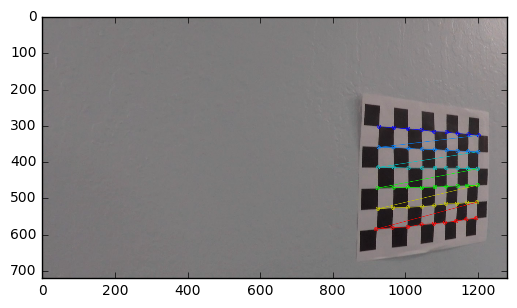

/calibration16.jpg


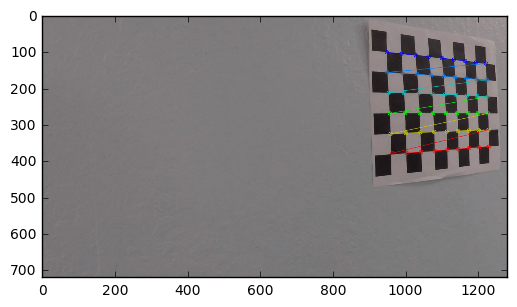

/calibration5.jpg
/calibration2.jpg


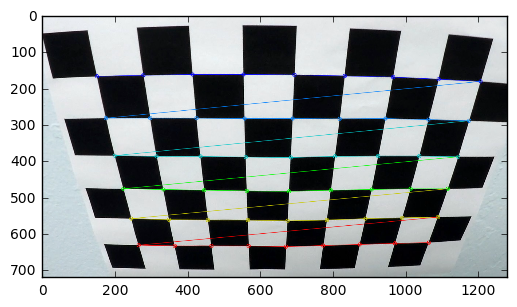

/calibration4.jpg
/calibration7.jpg


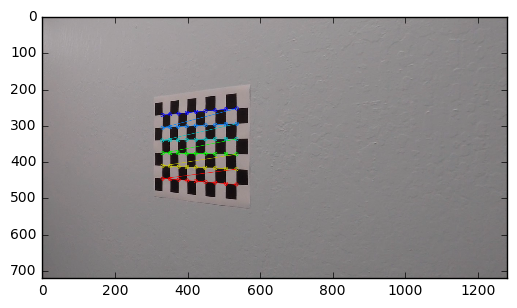

/calibration3.jpg


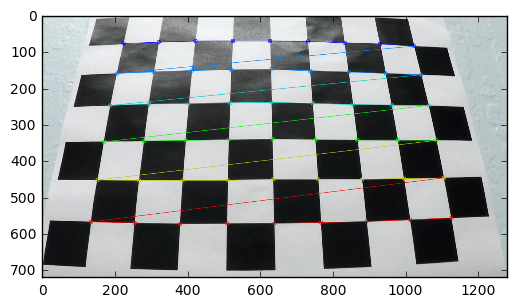

/calibration18.jpg


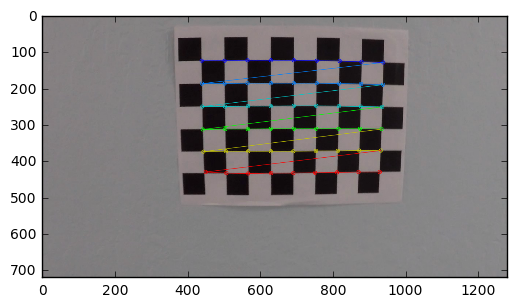

/calibration6.jpg


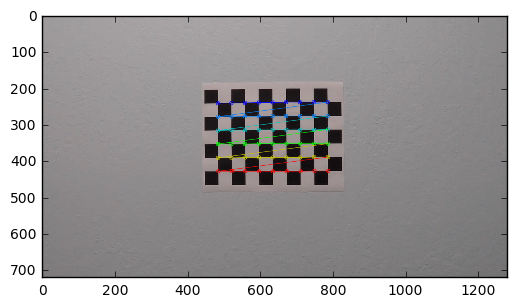

/calibration10.jpg


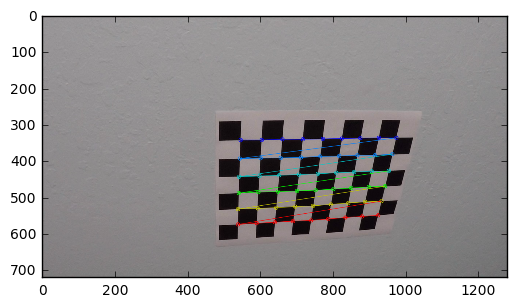

/calibration1.jpg
/calibration12.jpg


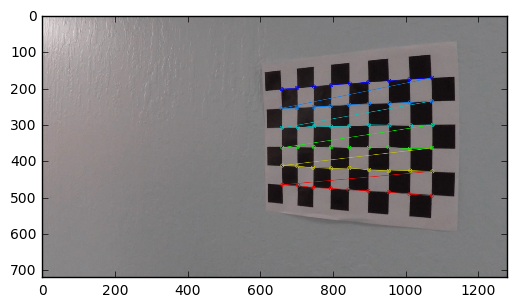

/calibration14.jpg


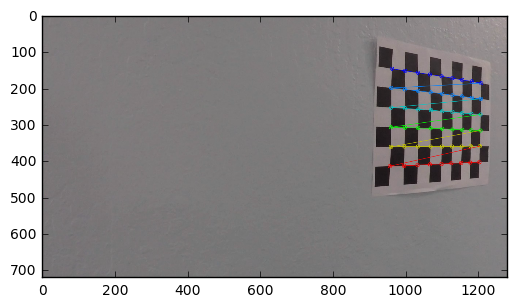

/calibration8.jpg


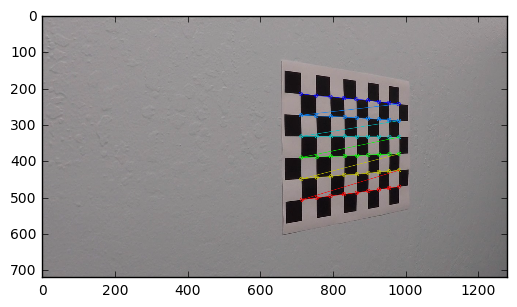

/calibration9.jpg


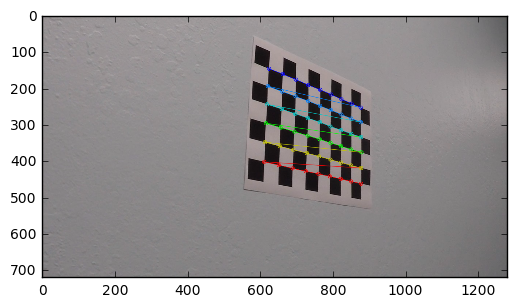

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    print(fname[12:])
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        plt.show()

In [2]:
def get_calibration_mat(imgpath, showChessboard = False):
    images = glob.glob(imgpath)
    
    for fname in images:
        
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            if showChessboard == True:
                # Draw and display the corners
                img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
                print(fname)
                plt.imshow(img)
                plt.show()
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

In [3]:
def undistort_img(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [4]:
mtx, dist = get_calibration_mat('./camera_cal/calibration*.jpg')

True

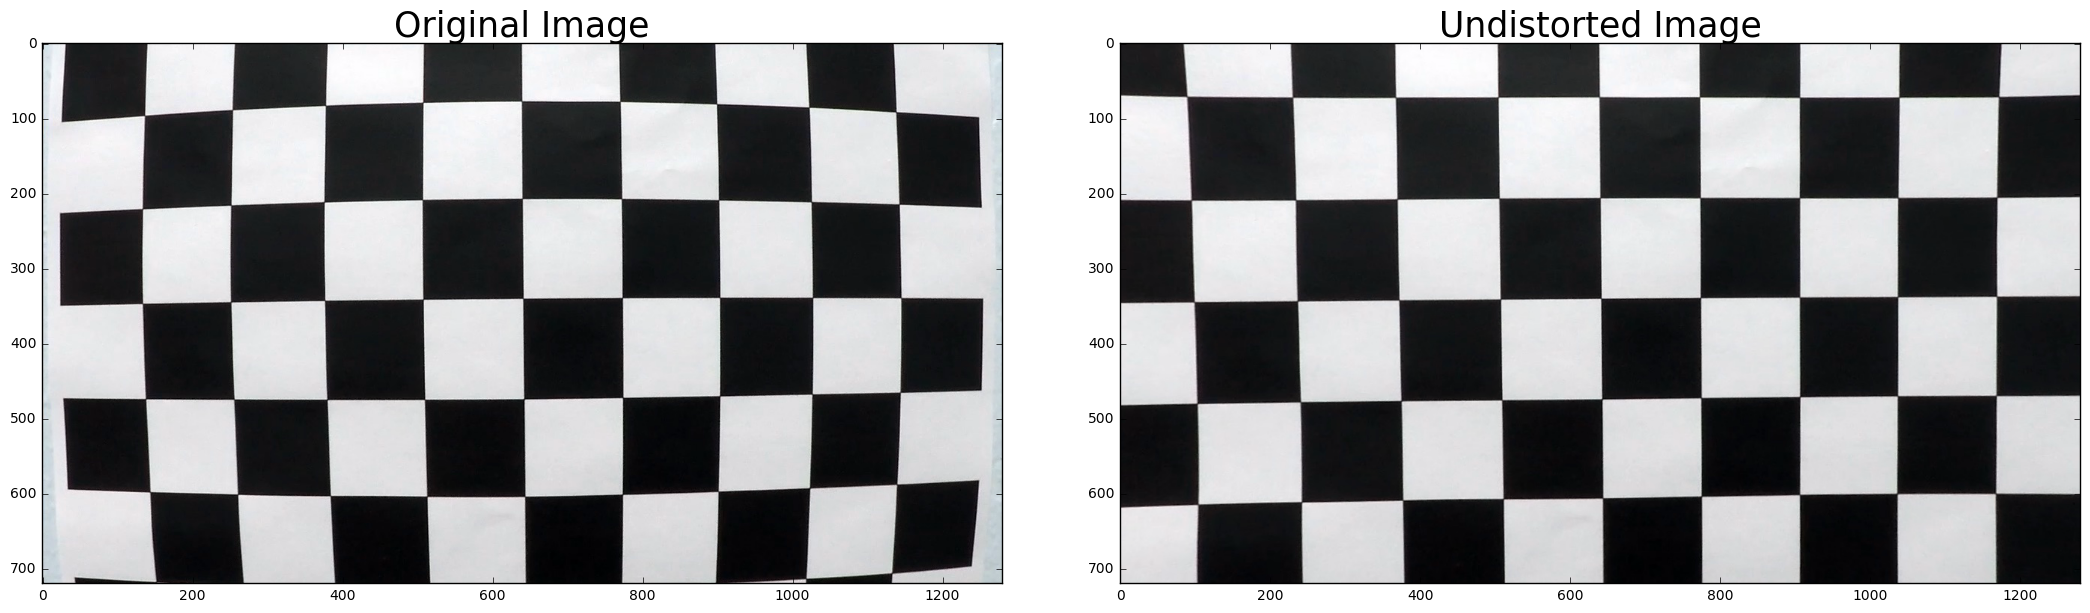

In [5]:
img = cv2.imread('./camera_cal/calibration1.jpg')
cv2.imwrite('./img/original_checkboard.jpg', img)

undimg = undistort_img(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 6))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(undimg)
ax2.set_title('Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite('./img/undistorted_checkboard.jpg', undimg)

## Image Thresholding
---
Thresholding: using HLS channel

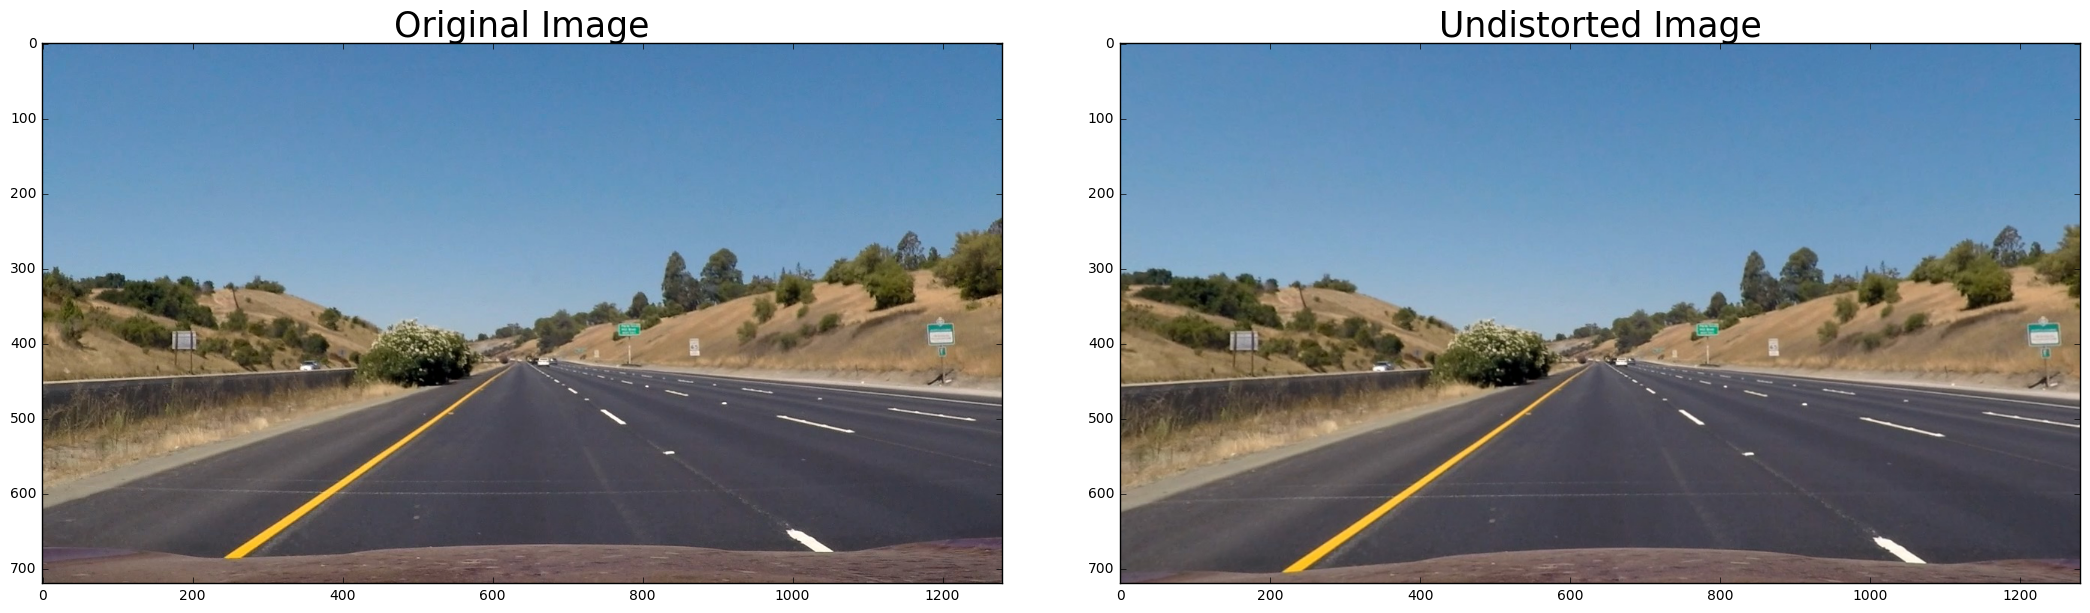

In [6]:
# load road image
img = cv2.imread('./test_images/straight_lines1.jpg')
undimg = undistort_img(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 6))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(cv2.cvtColor(undimg,cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### ROI trimming

In [118]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

function for trimming region of interest


image shape:  (720, 1280, 3)


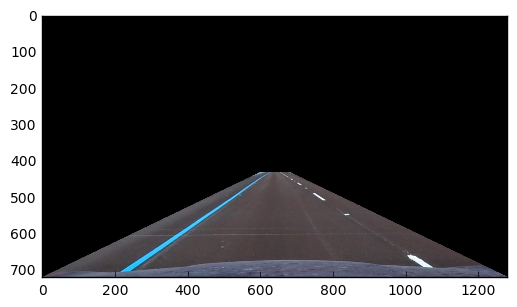

In [152]:
# get image size
imshape = undimg.shape
print("image shape: ", imshape)

# set roi
roi_vertices = np.array([[(0,imshape[0]), 
                        (imshape[1]*7/15, imshape[0]*3/5), 
                        (imshape[1]*8/15, imshape[0]*3/5), 
                        (imshape[1],imshape[0])]], 
                         dtype=np.int32)

# masking undistorted image (undimg)
maskimg = region_of_interest(undimg, roi_vertices)

# plot
plt.figure()
plt.imshow(maskimg)

In [153]:
hls = cv2.cvtColor(maskimg, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

In [154]:
print(H.dtype)

uint8


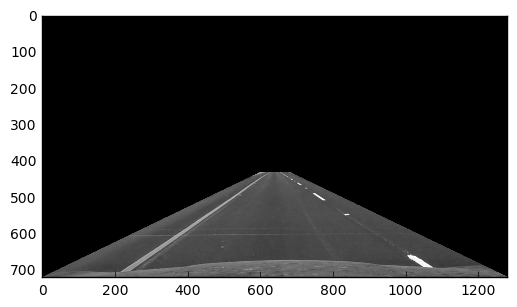

In [155]:
plt.imshow(L, cmap='gray')

In [156]:
def color_thres(hls, h_min=0, h_max=255, l_min=0, l_max=255, s_min=0, s_max=255):
    # decompose
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    # combine
    binary = np.zeros_like(H)
    binary[(H >= h_min) & (H <= h_max) & (L >= l_min) & (L <= l_max) & (S >= s_min) & (S <= s_max)] = 1
    
    return binary

In [157]:
hls = cv2.cvtColor(maskimg, cv2.COLOR_BGR2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

R = maskimg[:,:,2]
G = maskimg[:,:,1]
B = maskimg[:,:,0]

### Check color channel: HLS, RGB

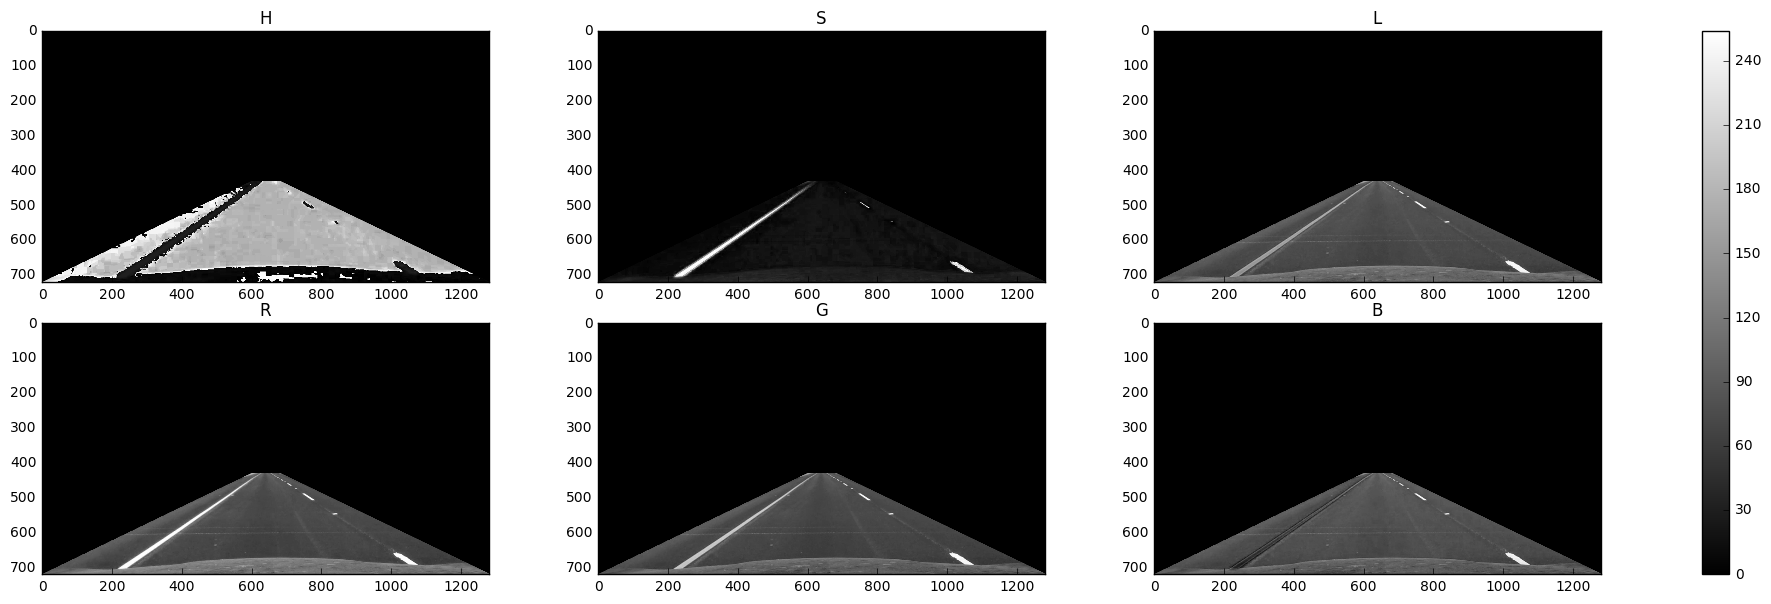

In [158]:
fig, axes = plt.subplots(2, 3, figsize=(21, 6))
fig.tight_layout()

axes[0,0].imshow(H, cmap='gray')
axes[0,1].imshow(S, cmap='gray')
axes[0,2].imshow(L, cmap='gray')
axes[0,0].set_title('H')
axes[0,1].set_title('S')
axes[0,2].set_title('L')


axes[1,0].imshow(R, cmap='gray')
axes[1,1].imshow(G, cmap='gray')
im = axes[1,2].imshow(B, cmap='gray')
axes[1,0].set_title('R')
axes[1,1].set_title('G')
axes[1,2].set_title('B')


fig.colorbar(im, ax=axes.ravel().tolist())


### color thresholding using S,L
color thresholding for extract yellow and white lane line from image

I used S and L channel each for finding yellow and white lane line

* S > 150 for yellow
* L > 180 for white

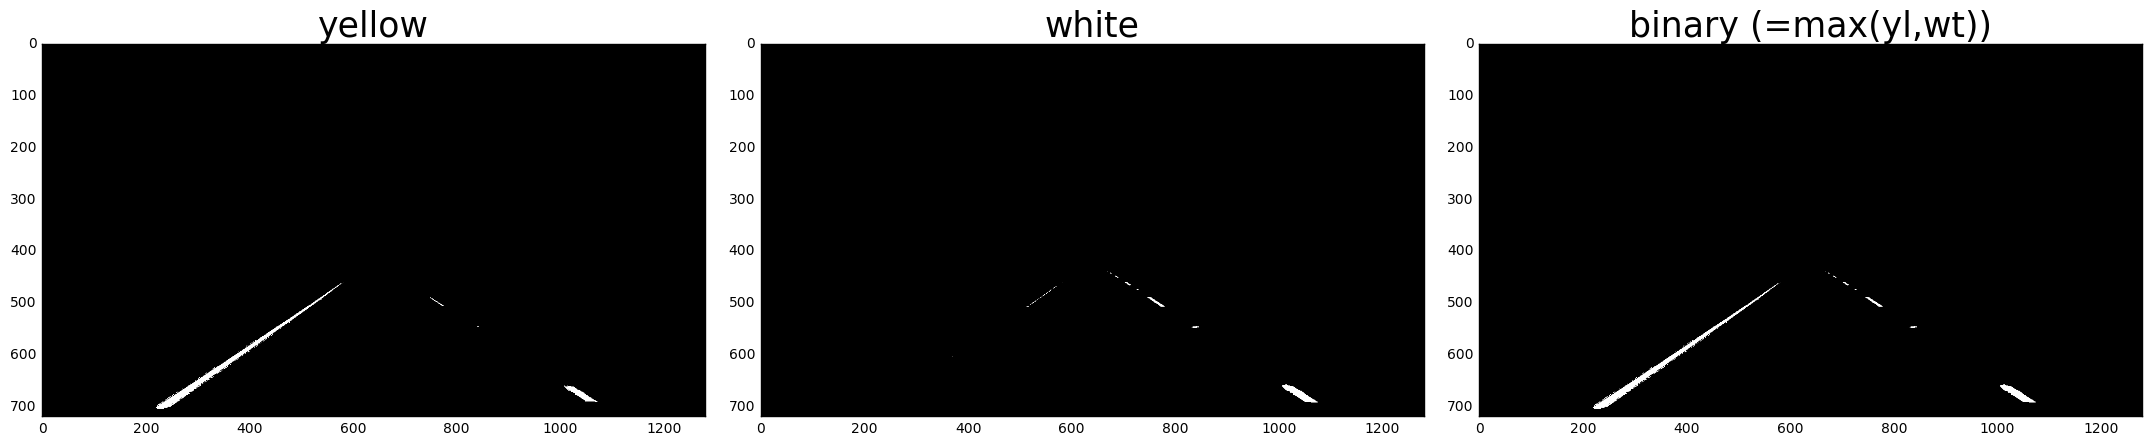

In [159]:
ylimg = color_thres(hls, s_min=150)
wtimg = color_thres(hls, l_min=180)

binary_color = np.zeros_like(ylimg)
binary_color = np.maximum(ylimg, wtimg)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))
f.tight_layout()
ax1.imshow(ylimg, cmap='gray')
ax1.set_title('yellow', fontsize=25)
ax2.imshow(wtimg, cmap='gray')
ax2.set_title('white', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
ax3.imshow(binary_color, cmap='gray')
ax3.set_title('binary (=max(yl,wt))', fontsize=25)

## Gradient Filter
---
using sobel operator

### final

In [162]:
finimg = binary_color

## Perspective Transform
---
Compute the perspective transform, M, given source and destination points:

```
M = cv2.getPerspectiveTransform(src, dst)
```

image shape: (720, 1280)


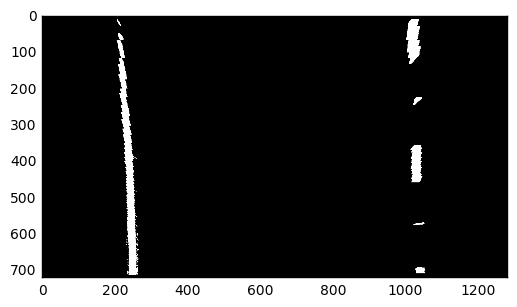

In [185]:
# Define image shape
image_shape = finimg.shape
print("image shape:",image_shape)
# Define the region
area_of_interest = [[150+430,460],[1150-440,460],[1150,720],[150,720]]

# Choose an offset from image corners to plot detected corners
offset1 = 200 # offset for dst points x value
offset2 = 0 # offset for dst points bottom y value
offset3 = 0 # offset for dst points top y value

# Grab the image shape
img_size = (finimg.shape[1], finimg.shape[0])

# For source points I'm grabbing the outer four detected corners
src = np.float32(area_of_interest)

# For destination points, I'm arbitrarily choosing some points to be
# a nice fit for displaying our warped result 
dst = np.float32([[offset1, offset3], 
                  [img_size[0]-offset1, offset3], 
                  [img_size[0]-offset1, img_size[1]-offset2], 
                  [offset1, img_size[1]-offset2]])

# calculate perspective transform
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

# warp the image 
binary_warped = cv2.warpPerspective(finimg, M, img_size)

# plot
plt.imshow(binary_warped, cmap='gray')
plt.show()

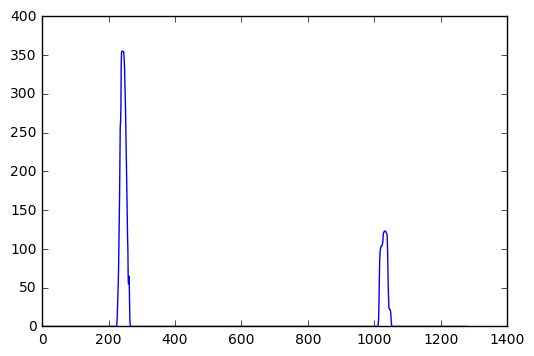

In [186]:
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
plt.plot(histogram)

In [188]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

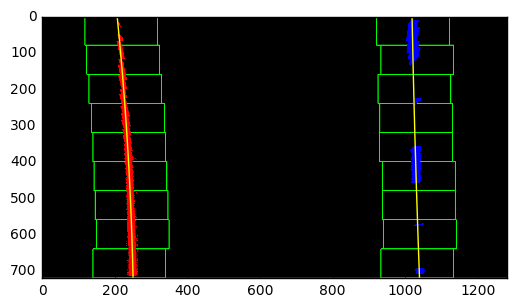

In [189]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

Skip the sliding windows step once you know where the lines are
Now you know where the lines are you have a fit! In the next frame of video you don't need to do a blind search again, but instead you can just search in a margin around the previous line position like this:

In [190]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

### And you're done! But let's visualize the result here as well

(720, 0)

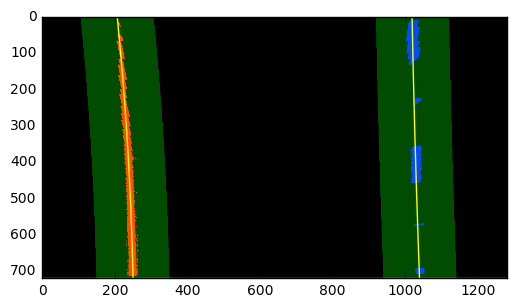

In [191]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Tracking

In [197]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # average x values of the fitted line over the last n iterations
        self.bestx = None     
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # distance in meters of vehicle center from the line
        self.line_base_pos = None 
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None

### Drawing
Once you have a good measurement of the line positions in warped space, it's time to project your measurement back down onto the road! Let's suppose, as in the previous example, you have a warped binary image called warped, and you have fit the lines with a polynomial and have arrays called ploty, left_fitx and right_fitx, which represent the x and y pixel values of the lines. You can then project those lines onto the original image as follows:


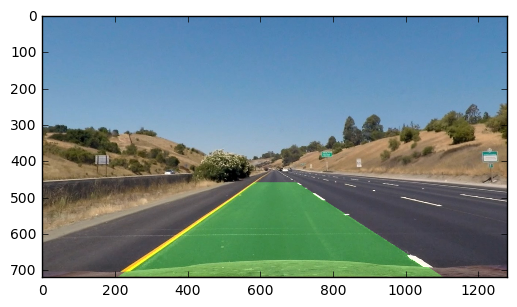

In [195]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (undimg.shape[1], undimg.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undimg, 1, newwarp, 0.3, 0)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))